In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import os

from cell_inference.config import paths, params
from cell_inference.utils.transform.data_transform import log_moulus_nfold
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import scaled_stats_indices, GRID_SHAPE
from cell_inference.utils.data_manager import NpzFilesCollector
from cell_inference.utils.metrics.corrcoef import cossim, corrcoef
import cell_inference.utils.feature_extractors.SummaryStats2D as ss2
import data_simulation_prediction

overwrite_saved_results = True
simulate_prediction = True
save_stats = True

## Select data

In [2]:
## In vivo data
invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikeWaveforms_NP_SUTempFilter_NPExample_v2'
# invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikes_NPUnits_large.h5'

## Simulation data
TRIAL_NAME = 'Reduced_Order_stochastic_spkwid_trunkLR4_LactvCa_Loc3_h1_Bio2' # select trial

## Trained model
model_name = 'CNN' # select model
# model_name = 'FCN'
# model_name = 'RF'

# stats_set_name = ''
# stats_set_name = 'GridStats'
stats_set_name = 'FullStats5'

isCNN = 'CNN' in model_name
if not isCNN and stats_set_name:
    model_name += '_' + stats_set_name

## Load data

#### Simulation data

In [3]:
DATA_PATH = paths.SIMULATED_DATA_PATH
TRIAL_PATH = os.path.join(DATA_PATH, TRIAL_NAME)

STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics
try:
    STATS = np.load(STATS_PATH)
except:
    STATS = NpzFilesCollector(STATS_PATH)
with STATS:
    sim_stats = STATS['x']

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = {k: v.copy() for p in ['loc', 'geo', 'bio'] \
    for k, v in config_dict['Simulation_Parameters'].get(p + '_param_range', {}).items()}
pred_p = config_dict['Prediction_Parameters']

print(inference_list)
label_list = inference_list.copy()

['s_nat', 's_kv3.1']


#### In vivo data

In [4]:
INVIVO_PATH = os.path.join(paths.INVIVO_DATA_PATH, invivo_name)
INVIVO_DATA_PATH = os.path.join(INVIVO_PATH, invivo_name + '.h5')
INVIVO_LFP_PATH = os.path.join(INVIVO_PATH, 'lfp_' + invivo_name + '.npz')  # LFP and labels
INVIVO_STATS_PATH = os.path.join(INVIVO_PATH, 'summ_stats_' + invivo_name + '.npz')  # summary statistics
INVIVO_FEATURE_PATH = os.path.join(INVIVO_PATH, 'features_' + invivo_name + '.csv')  # in vivo data features

with h5py.File(INVIVO_DATA_PATH,'r') as hf, np.load(INVIVO_LFP_PATH) as INVIVO_LFP:
    IDs = hf['ID'][()][INVIVO_LFP['good_indices']]

# Selected cell ID
IDs_index = pd.Index(IDs, name='ID')
select_ID = pred_p['cell_id']
IDs = np.asarray(select_ID).ravel()
select_idx = IDs_index.get_indexer(IDs)

with np.load(INVIVO_STATS_PATH) as INVIVO_STATS:
    invivo_stats = INVIVO_STATS['x'][select_idx]
    layer = INVIVO_STATS['layer'][select_idx] # use cortical layers as labels

#### Scale magnitude

In [5]:
max_mag_idx = [33, 38]
max_mag = np.amax(sim_stats[:, max_mag_idx], axis=1)
max_mag_invivo = np.amax(invivo_stats[:, max_mag_idx], axis=1)

mag_scale = np.mean(max_mag) / np.mean(max_mag_invivo)  # rematch the mean of simulated magnitude
# mag_scale = pred_p['magnitude_scale']  # use the scaling from previous predictions before inferring biophysical parameters
print(mag_scale)

scaled_idx = scaled_stats_indices()
invivo_stats_scaled = invivo_stats.copy()
invivo_stats_scaled[:, scaled_idx] *= mag_scale

0.19351828232175192


## Load model

In [6]:
isCNN = 'CNN' in model_name
isRF = 'RF' in model_name

if not isCNN and stats_set_name:
    summ_stats_id = np.loadtxt(os.path.join(TRIAL_PATH, stats_set_name + '_id.txt'), dtype=int)
    model_name += '_' + stats_set_name
else:
    summ_stats_id = np.arange(invivo_stats_scaled.shape[1])

In [7]:
import torch

MODEL_PATH = os.path.join(TRIAL_PATH, model_name)
PARAM_PATH = os.path.join(MODEL_PATH, model_name + ('.joblib' if isRF else '.pth'))

PRED_PATH = os.path.join(MODEL_PATH, model_name + '_prediction.csv')
if not os.path.isfile(PRED_PATH):
    INVIVO_PRED_PATH = os.path.join(MODEL_PATH, invivo_name)
    PRED_PATH = os.path.join(INVIVO_PRED_PATH, model_name + '_prediction.csv')
    if not os.path.exists(INVIVO_PRED_PATH):
        os.makedirs(INVIVO_PRED_PATH)
        print("The new data directory is created!")
else:
    INVIVO_PRED_PATH = MODEL_PATH
CORR_PATH = os.path.join(INVIVO_PRED_PATH, model_name + '_correlation.csv')
overwrite_saved_results = overwrite_saved_results or not os.path.isfile(PRED_PATH)

if isRF:
    import joblib
    model = joblib.load(PARAM_PATH)
else:
    if isCNN:
        from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork, ActivationTypes
        num_filters = [8, 16, 16, 32, 32, 64, 64, 64, 32, 8]
        model = ConvolutionalNetwork(in_channels=2, out_features=len(label_list), num_filters=num_filters)
    else:
        from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
        model = FullyConnectedNetwork(in_features=summ_stats_id.size, out_features=len(label_list))

    device = torch.device('cpu')
    model.load_state_dict(torch.load(PARAM_PATH, map_location=device))
    model.to(device)
    model.eval()

#### Data for CNN

In [8]:
n_fold = 30
max_logmod = np.ceil(np.log2(n_fold))  # max value after transform
n_fold = 2**max_logmod - 1

if overwrite_saved_results:
    if isCNN:
        with np.load(INVIVO_LFP_PATH) as INVIVO_LFP:
            invivo_lfp_scaled = 1000 * mag_scale * INVIVO_LFP['x'][select_idx]  # mV -> uV, then scale invivo lfp
        lfp_trans = np.empty_like(invivo_lfp_scaled)
        for i in range(invivo_lfp_scaled.shape[0]):
            lfp_trans[i] = log_moulus_nfold(invivo_lfp_scaled[i], n_fold)

        lfp_trans = np.stack((invivo_lfp_scaled, lfp_trans), axis=1)
        lfp_trans = lfp_trans.reshape(lfp_trans.shape[:3] + (GRID_SHAPE[0], -1))

### Predict on in vivo data

#### Normalization

In [9]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

In [10]:
if overwrite_saved_results:
    if isRF:
        pred = model.predict(invivo_stats_scaled[:, summ_stats_id])
    elif isCNN:
        pred = model(torch.Tensor(lfp_trans).to(device)).to("cpu").detach().numpy()
    else:
        pred = model(torch.Tensor(invivo_stats_scaled[:, summ_stats_id]).to(device)).to("cpu").detach().numpy()

    for i, lb in enumerate(label_list):
        pred[:, i] = org_scale(pred[:, i], ranges[lb])
    pred_list = label_list.copy()
    pred_dict = dict(zip(pred_list, pred.T))
    pred_dict['layer'] = layer

    df_pred = pd.DataFrame(pred_dict, index=IDs)
    df_pred.to_csv(PRED_PATH, index_label='cell id') # save to csv
    pred_idx = df_pred.index.get_indexer(IDs)
else:
    df_pred = pd.read_csv(PRED_PATH, index_col=0)
    pred_idx = df_pred.index.get_indexer(IDs)
    df_pred = df_pred.iloc[pred_idx]
    pred_dict = {key: np.array(value) for key, value in df_pred.to_dict(orient='list').items()}
    pred = df_pred.drop('layer', axis=1).to_numpy()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_pred)

,s_nat,s_kv3.1,layer
236,2.642164,2.758975,Layer5


## Simulate with predicted parameters

In [11]:
if INVIVO_PRED_PATH == MODEL_PATH:
    data_simulation_prediction.INVIVO_PRED_PATH = INVIVO_PRED_PATH
    data_simulation_prediction.set_path(trial=TRIAL_NAME, model=model_name)
else:
    data_simulation_prediction.set_path(trial=TRIAL_NAME, model=model_name, invivo=invivo_name)
PRED_LFP_PATH = data_simulation_prediction.PRED_LFP_PATH
PRED_STATS_PATH = data_simulation_prediction.PRED_STATS_PATH
if not os.path.isfile(PRED_LFP_PATH) or not os.path.isfile(PRED_STATS_PATH):
    if simulate_prediction:
        data_simulation_prediction.run_pred_simulation(config_dict, pred_dict, save_stats=save_stats)
    else:
        try:
            PRED_DATA = []
            if not os.path.isfile(PRED_LFP_PATH):
                PRED_DATA.append(NpzFilesCollector(PRED_LFP_PATH))
            if save_stats and not os.path.isfile(PRED_STATS_PATH):
                PRED_DATA.append(NpzFilesCollector(PRED_STATS_PATH))
        except:
            raise ValueError("Simulation data not generated for predictions.")
        else:
            for f in PRED_DATA:
                with f:
                    f.save_to_single_file() # convert data in multiple files to a single file
                    f.delete_files() # delete multiple files

## Evaluate prediction

In [12]:
with np.load(PRED_LFP_PATH, allow_pickle=True) as PRED_LFP:
    good_indices = PRED_LFP['valid'][PRED_LFP['good_indices']]  # valid simulated cell index
    pred_lfp = PRED_LFP['x'][np.isin(good_indices, pred_idx)]
    bad_indices = PRED_LFP['bad_indices'].item()

good_indices = np.isin(pred_idx, good_indices)  # valid in vivo cell index
with np.load(INVIVO_LFP_PATH) as INVIVO_LFP:
    invivo_lfp = INVIVO_LFP['x'][select_idx][good_indices]
    t = INVIVO_LFP['t']

invalid = np.full(IDs.size, True)
invalid[good_indices] = False
invalid = np.nonzero(invalid)[0]
ids = IDs[good_indices]

print('%d invalid IDs: ' % (len(invalid)))
print(IDs[invalid])
for bad, indices in bad_indices.items():
        print('Bad case %d: %d samples.' % (bad, np.count_nonzero(np.isin(indices, pred_idx))))

0 invalid IDs: 
[]
Bad case -1: 0 samples.
Bad case 0: 1 samples.
Bad case 1: 0 samples.
Bad case 2: 0 samples.
Bad case 3: 0 samples.


#### Calculate cosine similarity and correlation coefficient

In [13]:
corr = np.empty(pred_lfp.shape[0])  # linear scale
corr_log = np.empty(pred_lfp.shape[0])  # log modulus transformed
coss = np.empty(pred_lfp.shape[0])  # linear scale
coss_log = np.empty(pred_lfp.shape[0])  # log modulus transformed
for i in range(pred_lfp.shape[0]):
    log_invivo = log_moulus_nfold(invivo_lfp[i], n_fold)
    log_pred = log_moulus_nfold(pred_lfp[i], n_fold)
    corr[i] = corrcoef(invivo_lfp[i], pred_lfp[i])
    corr_log[i] = corrcoef(log_invivo, log_pred)
    coss[i] = cossim(invivo_lfp[i], pred_lfp[i])
    coss_log[i] = cossim(log_invivo, log_pred)

df_corr = pd.DataFrame({'Corr': corr, 'Log_Corr': corr_log, 'Coss': coss, 'Log_Coss': coss_log, 
                        'layer': layer[good_indices]}, index=ids).sort_values('Corr')
df_corr = pd.concat((pd.DataFrame({'Corr': np.nan, 'Log_Corr': np.nan, 'Coss': np.nan, 'Log_Coss': np.nan, 
                                   'layer': layer[invalid]}, index=IDs[invalid]), df_corr))
if overwrite_saved_results or not os.path.isfile(CORR_PATH):
    df_corr.to_csv(CORR_PATH, index_label='cell id')

print('Correlation of current predictions with inferred biophysical parameters:')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_corr)

Correlation of current predictions with inferred biophysical parameters:


,Corr,Log_Corr,Coss,Log_Coss,layer
236,0.657177,0.584865,0.657177,0.584865,Layer5


In [14]:
df_pre_pred_corr = pd.DataFrame(np.column_stack(list(pred_p['correlation'].values())),
    index=np.asarray(pred_p['cell_id']).ravel(), columns=pred_p['correlation'].keys())
print('Correlation of previous predictions before inferring biophysical parameters:')
display(df_pre_pred_corr)

Correlation of previous predictions before inferring biophysical parameters:


,Corr,Log_Corr,Coss,Log_Coss
236,0.720873,0.72576,0.720873,0.72576


### Check LFP

In [15]:
select_ID = IDs[0]
select_id = np.nonzero(ids==select_ID)[0][0]
select_stats = invivo_stats[good_indices][select_id]

display(df_pred.loc[[select_ID]])

,s_nat,s_kv3.1,layer
236,2.642164,2.758975,Layer5


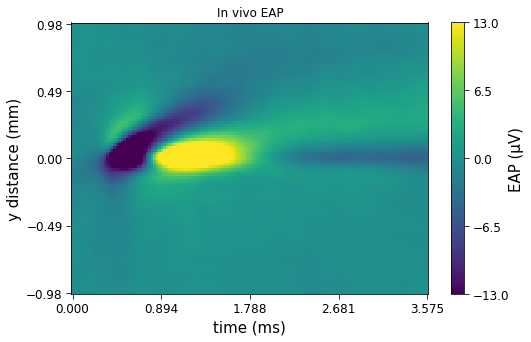

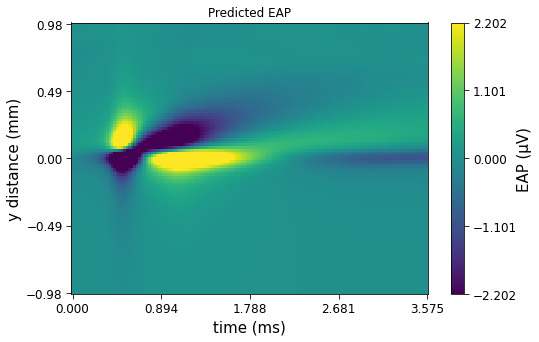

In [16]:
max_mag_idx_x = np.asarray(max_mag_idx) - 2  # max magnitue x idx
ix = int(select_stats[max_mag_idx_x][np.argmax(select_stats[max_mag_idx])])
fontsize = 15
labelpad = 0
ticksize = 12
tick_length = 5
nbins = 5

grid_shape = (ss2.GRID_SHAPE[0], ss2.NY)
elec_d = ss2.REL_IDX * ss2.DY
lfp_invivo = 1000 * invivo_lfp[select_id].reshape((-1,) + grid_shape)[:, ix, :]  # mV -> uV
lfp_pred = 1000 * pred_lfp[select_id].reshape((-1,) + grid_shape)[:, ix, :]

plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=elec_d, lfp=lfp_invivo,
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', colorbar_label='EAP (μV)', axes=plt.gca())
plt.ylabel('y distance (mm)')
plt.title('In vivo EAP')
plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=elec_d, lfp=lfp_pred,
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', colorbar_label='EAP (μV)', axes=plt.gca())
plt.ylabel('y distance (mm)')
plt.title('Predicted EAP')
plt.show()

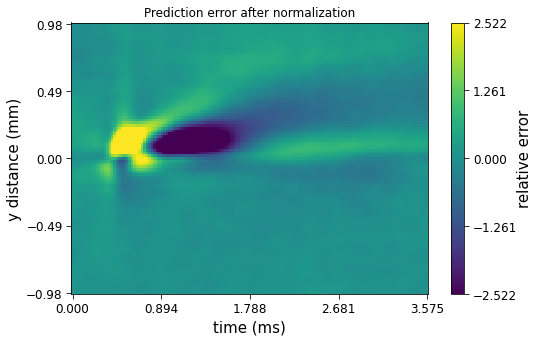

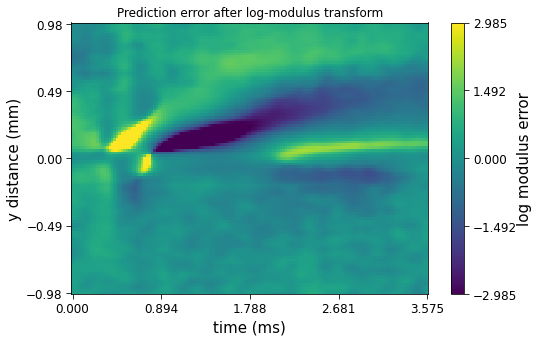

In [17]:
# relative error
rel_err = pred_lfp[select_id] / pred_lfp[select_id].std() - invivo_lfp[select_id] / invivo_lfp[select_id].std()
rel_err = rel_err.reshape((-1,) + grid_shape)[:, ix, :]
# log modulus error
log_err = log_moulus_nfold(pred_lfp[select_id], n_fold) - log_moulus_nfold(invivo_lfp[select_id], n_fold)
log_err = log_err.reshape((-1,) + grid_shape)[:, ix, :]

plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=elec_d, lfp=rel_err,
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', colorbar_label='relative error', axes=plt.gca())
plt.ylabel('y distance (mm)')
plt.title('Prediction error after normalization')
plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=elec_d, lfp=log_err,
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', colorbar_label='log modulus error', axes=plt.gca())
plt.ylabel('y distance (mm)')
plt.title('Prediction error after log-modulus transform')
plt.show()

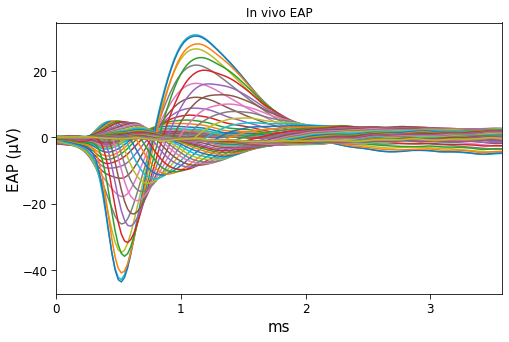

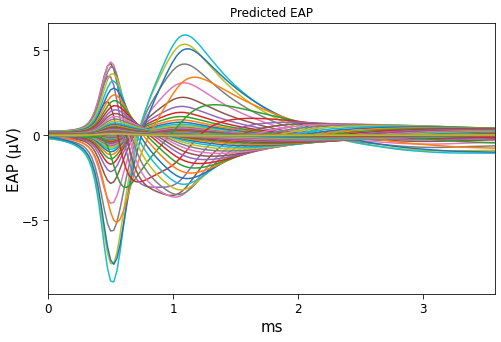

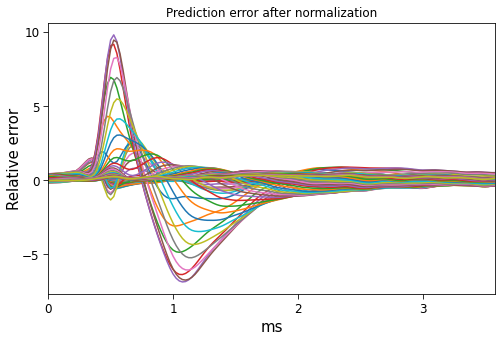

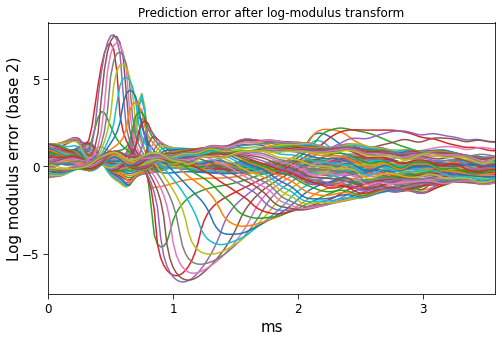

In [18]:
plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, lfp_invivo, #electrodes=elec_d,
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.gca().set_ylabel('EAP (μV)')
plt.title('In vivo EAP')
plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, lfp_pred, # electrodes=elec_d,
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.gca().set_ylabel('EAP (μV)')
plt.title('Predicted EAP')

plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, rel_err, # electrodes=elec_d,
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.title('Prediction error after normalization')
plt.ylabel('Relative error')
plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, log_err, # electrodes=elec_d,
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.title('Prediction error after log-modulus transform')
plt.ylabel('Log modulus error (base 2)')
plt.show()